# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**  

- **DateCrawled** — дата скачивания анкеты из базы  
- **VehicleType** — тип автомобильного кузова  
- **RegistrationYear** — год регистрации автомобиля  
- **Gearbox** — тип коробки передач  
- **Power** — мощность (л. с.)  
- **Model** — модель автомобиля  
- **Kilometer** — пробег (км)  
- **RegistrationMonth** — месяц регистрации автомобиля  
- **FuelType** — тип топлива  
- **Brand** — марка автомобиля  
- **NotRepaired** — была машина в ремонте или нет  
- **DateCreated** — дата создания анкеты  
- **NumberOfPictures** — количество фотографий автомобиля  
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)  
- **LastSeen** — дата последней активности пользователя  

**Целевой признак**  
- **Price** — цена (евро)  

## Подготовка данных

In [1]:
!pip3 install catboost

In [2]:
!pip install lightgbm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


import seaborn as sns
import collections

import warnings
warnings.filterwarnings('ignore')

In [4]:
autos = pd.read_csv('C:/Users/evche/Desktop/autos.csv')
display(autos.shape)
display(autos.info())
autos.head(5)

(354369, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
print('__ПРОПУСКИ__')
autos.isna().sum()

__ПРОПУСКИ__


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В столбцах **VehicleType**, **Gearbox**, **FuelType** и **NotRepaired** обнаружены пропуски.

- Выделим значимые признаки:

    - **VehicleType** Тип машины определяет ее возможности и оказывает влияние на финальную цену.
    - **RegistrationYear** Определяет количество лет эксплуатации автомобиля.
    - **Gearbox** Наличие автоматической коробки передач повышает стоимость.
    - **Power** Мощность в лошадиных силах (далее л.с.). Один из основных критериев формирования цены.
    - **Model** Определяет широкий спектр характеристик авто - сильно отражается на цене.  
    - **Kilometer** Обратно пропорциональная зависимость от цены. 
    - **FuelType** Определяет конструкцию двигателя, от которой тоже зависит цена.
    - **Brand** Как и марка, показывает качество и надежность автомобиля.
    - **NotRepaired** Наличие/отсутсвие участия в ДТП очень важная характеристика авто, которая может оказать значительное влияние на его стоимость.

Остальные столбцы не пригодятся для модели, так как не оказывают влияния на формирование стоимость авто.

- Теперь проанализируем численные значения отобранных признаков:

    - **RegistrationYear** Содержит некоторые аномальные значения, поэтому ограничим его периодом 1940-2020, оставшиеся показания приведем к ближайшей границе.
    - **Power** В данном столбце максимальное значение составляет 20000, что выглядит не слишком убедительно. На данный момент максильная мощность для автомобиля составляет 5000 л.с. (Devel Sixteen), на стенде мотор показал около 5007 л.с., но мы ограничимся круглым числом. 
    - **Price** Очень высокое стандартное отклонение, которое негативно отразится на работе алгоритма. Нуждается в поиске выбросов.


 - Дополнительно:
 
    - **VehicleType** Пропущенные значения восстановим по популярному типу из столбца Brand.
    - **Gearbox** Все NaN заменим на 'manual'.
    - **FuelType** Восстановим пропущенные значения по популярному типу из столбца Brand.
    - **NotRepaired** Для всех NaN установим значение 'yes'.
    - **Model** Для всех NaN - 'unknown'.

### Предобработка данных

Уберем из датафрейма столбцы, которые нам не пригодятся. 

In [7]:
autos_filtred = autos[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired',
                         'RegistrationYear',
                         'Model',                
                         'Price']]
autos_filtred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Gearbox           334536 non-null  object
 2   Power             354369 non-null  int64 
 3   Kilometer         354369 non-null  int64 
 4   FuelType          321474 non-null  object
 5   Brand             354369 non-null  object
 6   NotRepaired       283215 non-null  object
 7   RegistrationYear  354369 non-null  int64 
 8   Model             334664 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


**RegistrationYear**

In [8]:
def Balance_RegistrationYear(value):
    if value > 2020:
        return 2020
    elif value < 1930:
        return 1930
    else:
        return value
    
autos_filtred["RegistrationYear"] = autos_filtred["RegistrationYear"].apply(Balance_RegistrationYear)

**Power**

In [9]:
autos_filtred = autos_filtred.query('5 <= Power <= 5000')

**Price**.

count    313979.000000
mean       4705.026964
std        4590.752411
min           0.000000
25%        1250.000000
50%        2999.000000
75%        6890.000000
max       20000.000000
Name: Price, dtype: float64

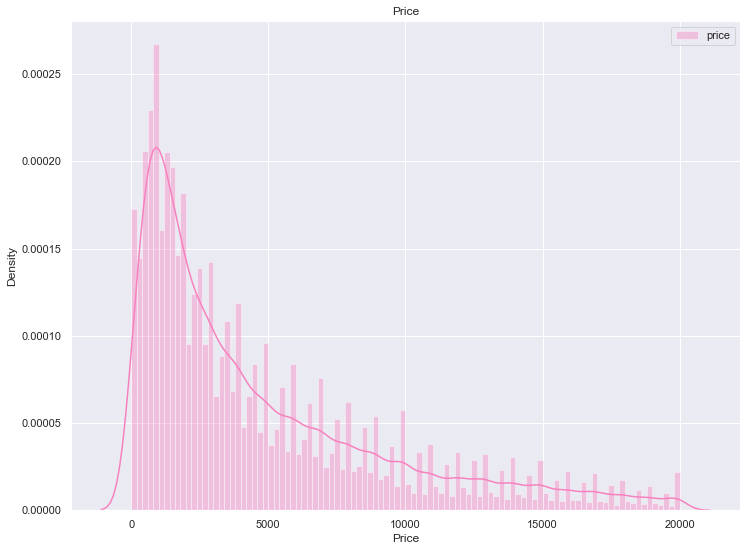

In [10]:
plt.figure(figsize=(12,9))
sns.set(style = 'darkgrid', palette = 'Set1_r')
sns.distplot(autos_filtred['Price'], bins=100, label = 'price')

plt.legend()
plt.title('Price')
autos_filtred['Price'].describe()

In [11]:
autos_filtred = autos_filtred.query('Price > 0')
q25=np.array(autos_filtred['Price'].quantile(0.25))
q75=np.array(autos_filtred['Price'].quantile(0.75))

first_part=q25-1.5*(q75-q25)
second_part=q75+1.5*(q75-q25)
    
del_index = []
    
for index_value, value in zip(autos_filtred['Price'].index, autos_filtred['Price']):
    if second_part <= value or value <= first_part:
        del_index.append(index_value)
    
print('Количество строк, выбранных для удаления :' , len(del_index))
autos_filtred = autos_filtred.drop(del_index,axis = 0)
print('Было удалено:', len(del_index))

Количество строк, выбранных для удаления : 13922
Было удалено: 13922


Замена NaN в **Gearbox, NotRepaired** и **Model**.

In [12]:
autos_filtred.fillna({'Gearbox':'manual', 
                           'NotRepaired':'yes',
                           'Model':'unknown'},
                          inplace=True)

Переведем два столбца в булев тип, это было бы удобно для дальнейшей работы.

- **IsAutoGearbox** 1(auto) - автомат. 0(manual) - механика.
- **IsNotRepaired** 1(yes) - означает машину без ремонта. 0(no) - с ремонтом.

In [13]:
autos_filtred['IsManualGearbox'] = 0
autos_filtred.loc[autos_filtred['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(autos_filtred['Gearbox'].value_counts())


autos_filtred['IsNotRepaired'] = 0
autos_filtred.loc[autos_filtred['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1
display(autos_filtred['NotRepaired'].value_counts())

manual    239249
auto       53913
Name: Gearbox, dtype: int64

no     217267
yes     75895
Name: NotRepaired, dtype: int64

**FuelType**

Изучим таблицу с распределением количества авто по типу топлива для каждой фирмы и заполним пропуски. 

In [14]:
display(autos_filtred['FuelType'].value_counts())
autos_filtred['FuelType'].isna().sum()

petrol      186040
gasoline     82086
lpg           4715
cng            498
hybrid         169
other           89
electric        65
Name: FuelType, dtype: int64

19500

In [15]:
fuel_type_table = autos_filtred.pivot_table(index=['FuelType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
display(fuel_type_table)

count                                                      \
              Price                                                       
Brand    alfa_romeo     audi      bmw chevrolet chrysler citroen  dacia   
FuelType                                                                  
cng             NaN      NaN      8.0       4.0      NaN     6.0    2.0   
electric        NaN      2.0      3.0       NaN      NaN     1.0    NaN   
gasoline      560.0  10044.0   9714.0     191.0    331.0  1411.0  182.0   
hybrid          NaN      1.0      NaN       NaN      NaN     NaN    NaN   
lpg            34.0    424.0    704.0     165.0     84.0    62.0   49.0   
other           NaN      1.0      4.0       NaN      NaN     NaN    NaN   
petrol       1272.0  12166.0  18302.0     990.0    684.0  2643.0  535.0   

                                  ...                                         \
                                  ...                                          
Brand    daewoo daihatsu    fiat  ...    seat   skoda   smart sonstige_autos   
FuelType                          ...                                          
cng         NaN      NaN    65.0  ...     3.0     6.0     2.0            6.0   
electric    NaN      1.0     3.0  ...     NaN     NaN     3.0           10.0   
gasoline    1.0      4.0  1261.0  ...  1518.0  1650.0   769.0          326.0   
hybrid      NaN      NaN     3.0  ...     1.0     NaN     1.0           15.0   
lpg        21.0      4.0    60.0  ...    59.0    49.0     3.0           93.0   
other       NaN      NaN     1.0  ...     NaN     NaN     NaN            8.0   
petrol    373.0    568.0  5980.0  ...  3987.0  2871.0  3616.0         1046.0   

                                                            
                                                            
Brand    subaru  suzuki  toyota trabant volkswagen   volvo  
FuelType                                                    
cng         2.0     NaN     NaN     NaN      175.0    20.0  
electric    NaN     NaN     NaN     NaN        4.0     NaN  
gasoline   31.0   207.0   890.0     1.0    21481.0   883.0  
hybrid      NaN     NaN    87.0     NaN        3.0     NaN  
lpg        27.0    17.0    19.0     NaN      494.0   104.0  
other       NaN     1.0     NaN    26.0       14.0     2.0  
petrol    522.0  1652.0  2842.0   214.0    37361.0  1585.0  

[7 rows x 40 columns]

In [16]:
autos_filtred.fillna({'FuelType':0},inplace=True)
fuel_type_table = fuel_type_table['count']['Price']
fuel_type_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,NaN,8.0,4.0,NaN,6.0,2.0,NaN,NaN,65.0,...,3.0,6.0,2.0,6.0,2.0,NaN,NaN,NaN,175.0,20.0
electric,NaN,2.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,3.0,...,NaN,NaN,3.0,10.0,NaN,NaN,NaN,NaN,4.0,NaN
gasoline,560.0,10044.0,9714.0,191.0,331.0,1411.0,182.0,1.0,4.0,1261.0,...,1518.0,1650.0,769.0,326.0,31.0,207.0,890.0,1.0,21481.0,883.0
hybrid,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,1.0,15.0,NaN,NaN,87.0,NaN,3.0,NaN
lpg,34.0,424.0,704.0,165.0,84.0,62.0,49.0,21.0,4.0,60.0,...,59.0,49.0,3.0,93.0,27.0,17.0,19.0,NaN,494.0,104.0
other,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,8.0,NaN,1.0,NaN,26.0,14.0,2.0
petrol,1272.0,12166.0,18302.0,990.0,684.0,2643.0,535.0,373.0,568.0,5980.0,...,3987.0,2871.0,3616.0,1046.0,522.0,1652.0,2842.0,214.0,37361.0,1585.0


In [17]:
def type_inputer(row, row_number, type_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = type_table[brand].idxmax()
    return fill_value

In [18]:
autos_filtred['FuelType'] = autos_filtred.apply(type_inputer, args=[4, fuel_type_table], axis=1)
display(autos_filtred['FuelType'].isna().sum())
autos_filtred['FuelType'].value_counts()

0

petrol      205528
gasoline     82098
lpg           4715
cng            498
hybrid         169
other           89
electric        65
Name: FuelType, dtype: int64

**VehicleType**

Воспользуемся тем же методом заполнения пропусков.

In [19]:
display(autos_filtred['VehicleType'].value_counts())
autos_filtred['VehicleType'].isna().sum()

sedan          79336
small          69603
wagon          56610
bus            24920
convertible    17006
coupe          13099
suv             9104
other           2416
Name: VehicleType, dtype: int64

21068

In [20]:
vehicle_type_table = autos_filtred.pivot_table(index=['VehicleType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])

In [21]:
autos_filtred.fillna({'VehicleType':0},inplace=True)
vehicle_type_table = vehicle_type_table['count']['Price']
vehicle_type_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,9.0,4.0,137.0,370.0,1139.0,43.0,25.0,32.0,713.0,...,564.0,223.0,NaN,147.0,15.0,25.0,409.0,NaN,8046.0,NaN
convertible,150.0,1313.0,2623.0,9.0,198.0,96.0,NaN,1.0,16.0,450.0,...,NaN,3.0,1050.0,228.0,1.0,27.0,60.0,30.0,2482.0,64.0
coupe,214.0,1020.0,3111.0,61.0,41.0,133.0,NaN,5.0,NaN,146.0,...,73.0,6.0,294.0,137.0,4.0,6.0,191.0,3.0,1395.0,64.0
other,11.0,85.0,206.0,30.0,7.0,95.0,6.0,4.0,7.0,141.0,...,48.0,18.0,4.0,104.0,4.0,11.0,14.0,2.0,617.0,4.0
sedan,838.0,9363.0,15255.0,194.0,240.0,619.0,95.0,91.0,39.0,783.0,...,1554.0,792.0,27.0,341.0,144.0,161.0,812.0,137.0,17361.0,578.0
small,219.0,1189.0,372.0,529.0,10.0,1424.0,214.0,217.0,440.0,4655.0,...,2852.0,1049.0,2977.0,172.0,107.0,887.0,1450.0,48.0,16240.0,6.0
suv,NaN,104.0,566.0,299.0,19.0,32.0,192.0,1.0,41.0,23.0,...,3.0,124.0,NaN,306.0,52.0,677.0,369.0,1.0,895.0,156.0
wagon,428.0,9530.0,6871.0,98.0,225.0,551.0,228.0,44.0,14.0,382.0,...,341.0,2374.0,9.0,95.0,265.0,77.0,503.0,51.0,11123.0,1758.0


In [22]:
autos_filtred['VehicleType'] = autos_filtred.apply(type_inputer, args=[0, vehicle_type_table], axis=1)
display(autos_filtred['VehicleType'].isna().sum())
autos_filtred['VehicleType'].value_counts()

0

sedan          89232
small          78792
wagon          58481
bus            24976
convertible    17023
coupe          13099
suv             9143
other           2416
Name: VehicleType, dtype: int64

**Вывод**

In [23]:
autos_filtred.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)
autos_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293162 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       293162 non-null  object
 1   Power             293162 non-null  int64 
 2   Kilometer         293162 non-null  int64 
 3   FuelType          293162 non-null  object
 4   Brand             293162 non-null  object
 5   RegistrationYear  293162 non-null  int64 
 6   Model             293162 non-null  object
 7   Price             293162 non-null  int64 
 8   IsManualGearbox   293162 non-null  int64 
 9   IsNotRepaired     293162 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 24.6+ MB


In [24]:
autos_filtred.isna().mean()

VehicleType         0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
RegistrationYear    0.0
Model               0.0
Price               0.0
IsManualGearbox     0.0
IsNotRepaired       0.0
dtype: float64

Все пропуски были заполнены, отобраны необходимые столбцы.  
При удалении выбросов был утрачен значимый процент данных, в данном случае такой шаг можно оправдать значительным ухудшением качества моделей под влиянием этих выбросов. Но, в целом, это не очень хорошо, и поэтому, если модель покажет плохие результаты, будет иметь смысл уменьшить объем объектов, идентифицируемых как выбросы. 

## Обучение моделей

### Признаки

Необходимо подготовить три различных типа признаков: неизмененные, закодированные OE, закодированные OHE. 

In [25]:
#Целевой признак
target = autos_filtred['Price']

In [26]:
#Неизмененные
original_features = autos_filtred.drop('Price', axis=1)

original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=12345)

In [27]:
#OE кодирование
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features), columns=cat_features.columns, index=cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]
    
    
ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

In [28]:
#OHE кодирование
ohe_features = pd.get_dummies(original_features, drop_first=True)

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

### CatBoostRegressor

- Обучим модель на данных, закодированных по методу OE.
- Обучим на оригинальных данных с указанием категорий.

In [29]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.2, 0.5, 0.7], 'random_state':[123456], 'verbose':[False]}]
print('___Tuning hyper-parameters for RMSE___')
print()

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set:", clf.best_params_)
print()

print("Grid scores (development set):")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f for %r"% ((mean*-1)** 0.5, params))
print()

CBR_ordinal_RMSE = (max(means)*-1) ** 0.5

___Tuning hyper-parameters for RMSE___

Best parameters set: {'learning_rate': 0.5, 'random_state': 123456, 'verbose': False}

Grid scores (development set):
1410.24223 for {'learning_rate': 0.2, 'random_state': 123456, 'verbose': False}
1405.95477 for {'learning_rate': 0.5, 'random_state': 123456, 'verbose': False}
1420.62752 for {'learning_rate': 0.7, 'random_state': 123456, 'verbose': False}

Wall time: 2min 8s


In [30]:
%%time
regressor = CatBoostRegressor(learning_rate=0.5, iterations = 250, random_state=123456, verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 
print('___Train for RMSE___')
print()

CBR_original_RMSE = (cross_val_score(regressor, original_features_train, target_train, cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Mean RMSE from CV of CatBoostRegressor =', CBR_original_RMSE)

___Train for RMSE___

Mean RMSE from CV of CatBoostRegressor = 1439.6484683074546
Wall time: 1min 4s


### LGBMRegressor

In [31]:
%%time
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[50, 100, 200], 'learning_rate':[0.1, 0.3, 0.5], 'random_state':[123456]}]
print('___Tuning hyper-parameters for RMSE___')
print()

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set:", clf.best_params_)
print()

print("Grid scores (development set):")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f for %r"% ((mean*-1)** 0.5, params))
print()

LGBMR_RMSE = (max(means)*-1) ** 0.5

___Tuning hyper-parameters for RMSE___

Best parameters set: {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 123456}

Grid scores (development set):
1472.18543 for {'learning_rate': 0.1, 'num_leaves': 50, 'random_state': 123456}
1434.85849 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 123456}
1404.34540 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 123456}
1428.90676 for {'learning_rate': 0.3, 'num_leaves': 50, 'random_state': 123456}
1407.64514 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 123456}
1396.18358 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 123456}
1434.96419 for {'learning_rate': 0.5, 'num_leaves': 50, 'random_state': 123456}
1422.48956 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 123456}
1422.47606 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 123456}

Wall time: 20 s


### LinearRegression

Необходимо сравнить результаты градиентного бустинга с простыми моделями. Для начала возьмем линейную регрессию.

In [32]:
%%time
regressor = LinearRegression()
print('___Train RMSE___')
print()

LR_RMSE = (cross_val_score(regressor, ohe_features_train, target_train, cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Mean RMSE from CV of LinearRegression =', LR_RMSE)

___Train RMSE___

Mean RMSE from CV of LinearRegression = 2387.5179753004336
Wall time: 10.5 s


Попробуем масштабировать данные.

In [33]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('___Train RMSE___')
print()

LR_RMSE_S = (cross_val_score(pipeline, ohe_features_train, target_train, cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Mean RMSE from CV of LinearRegression =', LR_RMSE_S)

___Train RMSE___

Mean RMSE from CV of LinearRegression = 6290952338458.871
Wall time: 17.5 s


Масштабирование очень сильно ухудшило ситуацию, не будем использовать.

### Ridge

Гребневую регрессию в данном случае, тоже используем в качестве более простой модели для сравнения. 

In [34]:
autos_filtred.corr()

,Power,Kilometer,RegistrationYear,Price,IsManualGearbox,IsNotRepaired
Power,1.000000,0.105573,0.054149,0.339301,-0.305452,-0.040135
Kilometer,0.105573,1.000000,-0.220189,-0.336609,-0.028565,0.093314
RegistrationYear,0.054149,-0.220189,1.000000,0.412429,-0.010370,-0.079961
Price,0.339301,-0.336609,0.412429,1.000000,-0.221828,-0.260767
IsManualGearbox,-0.305452,-0.028565,-0.010370,-0.221828,1.000000,0.034961
IsNotRepaired,-0.040135,0.093314,-0.079961,-0.260767,0.034961,1.000000


In [35]:
%%time

regressor = Ridge()
hyperparams = [{'alpha':[0.1, 1, 10, 100], 'solver':['auto']},
                 {'alpha':[0.1, 1, 10, 100], 'solver':['svd']}, 
                 {'alpha':[0.1, 1, 10, 100], 'solver':['cholesky']},
                 {'alpha':[0.1, 1, 10, 100], 'solver':['lsqr']}, 
                 {'alpha':[0.1, 1, 10, 100], 'solver':['sparse_cg']}]

print('___Train hyper-parameters for RMSE___')
print()


clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set:", clf.best_params_)
print()

print("Grid scores (development set):")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f for %r"% ((mean*-1)** 0.5, params))
print()

R_RMSE = (max(means)*-1) ** 0.5

___Train hyper-parameters for RMSE___

Best parameters set: {'alpha': 1, 'solver': 'auto'}

Grid scores (development set):
2387.48290 for {'alpha': 0.1, 'solver': 'auto'}
2387.38130 for {'alpha': 1, 'solver': 'auto'}
2388.19192 for {'alpha': 10, 'solver': 'auto'}
2403.68841 for {'alpha': 100, 'solver': 'auto'}
2387.48290 for {'alpha': 0.1, 'solver': 'svd'}
2387.38130 for {'alpha': 1, 'solver': 'svd'}
2388.19192 for {'alpha': 10, 'solver': 'svd'}
2403.68841 for {'alpha': 100, 'solver': 'svd'}
2387.48290 for {'alpha': 0.1, 'solver': 'cholesky'}
2387.38130 for {'alpha': 1, 'solver': 'cholesky'}
2388.19192 for {'alpha': 10, 'solver': 'cholesky'}
2403.68841 for {'alpha': 100, 'solver': 'cholesky'}
3503.84952 for {'alpha': 0.1, 'solver': 'lsqr'}
3503.84952 for {'alpha': 1, 'solver': 'lsqr'}
3503.84952 for {'alpha': 10, 'solver': 'lsqr'}
3503.84952 for {'alpha': 100, 'solver': 'lsqr'}
3203.49431 for {'alpha': 0.1, 'solver': 'sparse_cg'}
3203.49431 for {'alpha': 1, 'solver': 'sparse_cg'}
3203.

### DecisionTreeRegressor

В заключении воспользуемся деревом решений.  
Воспользуемся двумя различными типами признаков: 
- OHE
- OE

In [36]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(1, 25, 3)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[123456]}]
print('___Train hyper-parameters for RMSE___')
print()


clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set:", clf.best_params_)
print()

print("Grid scores (development set):")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f for %r"% ((mean*-1)** 0.5, params))
print()

DTR_ohe_RMSE = (max(means)*-1) ** 0.5

___Train hyper-parameters for RMSE___

Best parameters set: {'criterion': 'mse', 'max_depth': 16, 'random_state': 123456}

Grid scores (development set):
3059.49004 for {'criterion': 'mse', 'max_depth': 1, 'random_state': 123456}
2291.76655 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 123456}
1890.82940 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 123456}
1733.19506 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 123456}
1660.14522 for {'criterion': 'mse', 'max_depth': 13, 'random_state': 123456}
1640.84148 for {'criterion': 'mse', 'max_depth': 16, 'random_state': 123456}
1646.65275 for {'criterion': 'mse', 'max_depth': 19, 'random_state': 123456}
1666.13426 for {'criterion': 'mse', 'max_depth': 22, 'random_state': 123456}

Wall time: 2min 4s


In [37]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(1, 15)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[123456]}]
print('___Tuning hyper-parameters for RMSE___')
print()

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set:", clf.best_params_)
print()

print("Grid scores (development set):")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f for %r"% ((mean*-1)** 0.5, params))
print()

DTR_ordinal_RMSE = (max(means)*-1) ** 0.5

___Tuning hyper-parameters for RMSE___

Best parameters set: {'criterion': 'mse', 'max_depth': 13, 'random_state': 123456}

Grid scores (development set):
3059.49004 for {'criterion': 'mse', 'max_depth': 1, 'random_state': 123456}
2732.79804 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 123456}
2526.96986 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 123456}
2292.12341 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 123456}
2125.55744 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 123456}
1996.65247 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 123456}
1897.97014 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 123456}
1824.52778 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 123456}
1771.38427 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 123456}
1730.17416 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 123456}
1693.98203 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 123456}
1670.29

## Анализ моделей

Для каждой из рассмотренных моделей были выбраны лучшие гиперпараметры. Проведем обучение.

### CatBoostRegressor

Для начала обучим на данных, которые закодированы по методу OE.

In [38]:
%%time

model = CatBoostRegressor(learning_rate=0.5, random_state=123456, verbose=False) 
model.fit(ordinal_features_train, target_train)

Wall time: 9.38 s


In [39]:
%%time

target_predict = model.predict(ordinal_features_test)

Wall time: 15 ms


In [40]:
final_RMSE_CBR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of CatBoostRegressor =', CBR_ordinal_RMSE)

final_RMSE of CatBoostRegressor = 1405.954772303745


Теперь на оригинальных.

In [41]:
%%time

model = CatBoostRegressor(learning_rate=0.5, iterations = 250, random_state=123456, verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

Wall time: 15.3 s


In [42]:
%%time

target_predict = model.predict(original_features_test)

Wall time: 74 ms


In [43]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of CatBoostRegressor =', final_RMSE_CBR_original)

final_RMSE of CatBoostRegressor = 1450.5889406794963


### LGBMRegressor

In [44]:
%%time

model = LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=123456)
model.fit(ordinal_features_train, target_train)

Wall time: 566 ms


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=123456)

In [45]:
%%time

target_predict = model.predict(ordinal_features_test)

Wall time: 69.8 ms


In [46]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of LGBMRegressor =', final_RMSE_LGBMR)

final_RMSE of LGBMRegressor = 1406.9239480149747


### LinearRegression

In [47]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

Wall time: 2.37 s


LinearRegression()

In [48]:
%%time

target_predict = model.predict(ohe_features_test)

Wall time: 128 ms


In [49]:
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of LinearRegression =', final_RMSE_LR)

final_RMSE of LinearRegression = 2406.889981120662


### Ridge

In [50]:
%%time

model = Ridge(alpha=1, solver='svd')
model.fit(ohe_features_train, target_train)

Wall time: 3.58 s


Ridge(alpha=1, solver='svd')

In [51]:
%%time

target_predict = model.predict(ohe_features_test)

Wall time: 127 ms


In [52]:
final_RMSE_R = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of Ridge =', final_RMSE_R)

final_RMSE of Ridge = 2406.9253888427447


### DecisionTreeRegressor

OHE

In [53]:
%%time

model = DecisionTreeRegressor(criterion='mse',  max_depth=16, random_state=123456) 
model.fit(ohe_features_train, target_train)

Wall time: 4.82 s


DecisionTreeRegressor(max_depth=16, random_state=123456)

In [54]:
%%time

target_predict = model.predict(ohe_features_test)

Wall time: 95.7 ms


In [55]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of DecisionTreeRegressor =', final_RMSE_DTR_ohe)

final_RMSE of DecisionTreeRegressor = 1640.6558006868995


OE

In [56]:
%%time

model = DecisionTreeRegressor(criterion='mse',  max_depth=13, random_state=123456) 
model.fit(ordinal_features_train, target_train)

Wall time: 381 ms


DecisionTreeRegressor(max_depth=13, random_state=123456)

In [57]:
%%time

target_predict = model.predict(ordinal_features_test)

Wall time: 11.9 ms


In [59]:
final_RMSE_DTR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5
print('final_RMSE of DecisionTreeRegressor =', final_RMSE_DTR_ordinal)

final_RMSE of DecisionTreeRegressor = 1668.135712246608


### Сравнение

In [60]:
index = ['CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor',
         'LinearRegression',
         'Ridge',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features']

data = {'RMSE на CV, €':[ CBR_ordinal_RMSE,
                            CBR_original_RMSE,
                            LGBMR_RMSE,
                            LR_RMSE,
                            R_RMSE,
                            DTR_ohe_RMSE,
                            DTR_ordinal_RMSE],
        
        'Время обучения на CV, сек':[128,
                                     64,
                                     20,
                                     10.5,
                                     130,
                                     124,
                                     13.7],
        
        'RMSE модели на тестовой выборке, €':[final_RMSE_CBR_ordinal,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR,
                                                final_RMSE_LR,
                                                final_RMSE_R,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_DTR_ordinal],
        'Время обучения модели, сек':[9.38,
                                      15.3,
                                      0.566,
                                      2.37,
                                      3.58,
                                      4.82,
                                      0.0381],
        
        'Время предсказания модели, сек':[0.015,
                                          0.074,
                                          0.698,
                                          0.128,
                                          0.127,
                                          0.957,
                                          0.119]}



Regression = pd.DataFrame(data=data, index=index)   
Regression

,"RMSE на CV, €","Время обучения на CV, сек","RMSE модели на тестовой выборке, €","Время обучения модели, сек","Время предсказания модели, сек"
CatBoostRegressor on OE features,1405.954772,128.0,1418.657121,9.3800,0.015
CatBoostRegressor on original features,1439.648468,64.0,1450.588941,15.3000,0.074
LGBMRegressor,1396.183576,20.0,1406.923948,0.5660,0.698
LinearRegression,2387.517975,10.5,2406.889981,2.3700,0.128
Ridge,2387.381305,130.0,2406.925389,3.5800,0.127
DecisionTreeRegressor on OHE features,1640.841478,124.0,1640.655801,4.8200,0.957
DecisionTreeRegressor on OE features,1657.803264,13.7,1668.135712,0.0381,0.119


Итак, мы получили все результаты, но для того, чтобы определить лучшую модель, необходимо ввести какой-то рейтинг. Нам необходимо выбрать регрессор с наименьшими значениями. Для этой цели в каждом столбце выделим минимальное значение, которое получит наибольший рейтинг - 1. После чего посчитаем итоговый. Время обучения на кросс-валидации не учитываем, т.к. для каждого типа данных это актуально только один раз.  

In [63]:
rate = pd.DataFrame(data=data, index=index)

rate['Рейтинг RMSE'] = ((rate['RMSE на CV, €'].min() /
                              rate['RMSE на CV, €']) + (rate['RMSE модели на тестовой выборке, €'].min() /
                              rate['RMSE модели на тестовой выборке, €']))
rate['Рейтинг времени обучения'] = (rate['Время обучения модели, сек'].min() / 
                              rate['Время обучения модели, сек'])
rate['Рейтинг времени предсказания'] = (rate['Время предсказания модели, сек'].min() / 
                              rate['Время предсказания модели, сек'])
rate['Итоговый рейтинг'] =  (rate['Рейтинг времени обучения'] +
                             rate['Рейтинг времени предсказания'] +
                             rate['Рейтинг RMSE'])

rate = rate[['Рейтинг RMSE', 'Рейтинг времени обучения', 'Рейтинг времени предсказания', 'Итоговый рейтинг']]

rate.sort_values(['Итоговый рейтинг'], ascending = False)

,Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
CatBoostRegressor on OE features,1.984780,0.004062,1.000000,2.988841
DecisionTreeRegressor on OE features,1.685600,1.000000,0.126050,2.811650
CatBoostRegressor on original features,1.939707,0.002490,0.202703,2.144900
LGBMRegressor,2.000000,0.067314,0.021490,2.088804
DecisionTreeRegressor on OHE features,1.708432,0.007905,0.015674,1.732011
LinearRegression,1.169325,0.016076,0.117188,1.302588
Ridge,1.169350,0.010642,0.118110,1.298102


Лучшей моделью по трем параметрам: качество, скорость обучения и скорость предсказания - можно считать **CatBoostRegressor**. Немного отстает **DecisionTreeRegressor** (с подготовленными признаками), но для задач, в которых необходимо бысторое решение с достаточной точностью, можно использовать. Остальные значительно отстают.  

Что касается точности: **LGBMRegressor** показала лучший результат.  
Самое быстрое предсказание делает **CatBoostRegressor**.  
Лучшее время обучения у **DecisionTreeRegressor**.  

**Ridge** показала себя хуже всего.

 